# Few Shot Learning for Classification

The aim of this notebook is to implement the Prototypical Networks for few-shot classification.

Let's start by importing all the packages needed:

In [1]:
# %pip install easyfsl

In [2]:
# import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18

import matplotlib.pyplot as plt

# Package to make loops graphical
from tqdm import tqdm

# Custom package to help with the few shot classification
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

And let's check that everything's working:

In [3]:
x = torch.rand(5, 3)
print(x)

tensor([[0.5665, 0.2255, 0.1458],
        [0.2225, 0.9176, 0.6017],
        [0.3126, 0.3332, 0.3379],
        [0.9840, 0.9965, 0.9548],
        [0.6636, 0.1854, 0.9870]])


First of all, we need a dataset, and Omniglot would actually be the best test for this kind of classification. It contains 1623 characters from 50 different alphabets and each character has been written by 20 different people.

In [4]:
image_size = 28

# training dataset
train_set = Omniglot( 
    root="./data",
    background=True, # select the train set
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3), # transform the images in 3-channels gray scale
            transforms.RandomResizedCrop(image_size), # apply a random resize crop
            transforms.RandomHorizontalFlip(), # apply a random horizontal flip transformation
            transforms.ToTensor(), # convert the images to Pytorch tensors
        ]
    ),
    download=True,
)
# test dataset
test_set = Omniglot(
    root="./data",
    background=False, # select the test set
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3), # transform the images in 3-channels gray scale
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]), # resize the images to a bit larger dimension
            transforms.CenterCrop(image_size), # center crop the image
            transforms.ToTensor(), # convert the images to Pytorch tensors
        ]
    ),
    download=True,
)

Files already downloaded and verified
Files already downloaded and verified


Let's start by giving an introduction to few-shot classification. In a few-shot classification task you have a labeled support set and a query set. For each image of the query set, we want to predict a label from the labels present in the support set. Therefore a few-shot classification model has to use the information from the support set to classify query images.  
It is called few-shot because the support set contains very few examples (as for example images). It may be also referred as N-way K-shots classification task: N is the number of classes whereas K is the number of examples per class.

We expect a model that has never seen any Saint-Bernard, Pug or Labrador during its training to successfully predict the query labels. The support set is the only information that the model has regarding what a Saint-Bernard, a Pug or a Labrador can be.  
Most few-shot classification methods are *metric-based*. It works in two phases:  
1) they use a CNN to project both support and query images into a feature space  
2) they classify query images by comparing them to support images. If, in the feature space, an image is closer to pugs than it is to labradors and Saint-Bernards, we will guess that it's a pug.

From there, we have two challenges :

1. Find the good feature space. This is what convolutional networks are for. A CNN is basically a function that takes an image as input and outputs a representation (or *embedding*) of this image in a given feature space. The challenge here is to have a CNN that will
project images of the same class into representations that are close to each other, even if it has not been trained
on objects of this class.
2. Find a good way to compare the representations in the feature space. This is the job of Prototypical Networks.

From the support set, Prototypical Networks compute a prototype for each class, which is the mean of all embeddings
of support images from this class. Then, each query is simply classified as the nearest prototype in the feature space,
with respect to euclidean distance.

1. We initiate `PrototypicalNetworks` with a *backbone*. This is the feature extractor we were talking about.
Here, we use as backbone a ResNet18 pretrained on ImageNet, with its head chopped off and replaced by a `Flatten`
layer. The output of the backbone, for an input image, will be a 512-dimensional feature vector.
2. The forward method doesn't only take one input tensor, but 3: in order to predict the labels of query images,
we also need support images and labels as inputs of the model.

In [5]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module): # take a model 'backbone' (NN) as argument to extract characteristics from the support and query images
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        Takes in input the support images and the relative labels and the query images.
        """
        # Extract the features of support and query images to get the embeddings
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores # smaller distances correspond to higher scores

# ResNet18 è una rete neurale convoluzionale pre-addestrata che è spesso utilizzata come backbone per molte applicazioni di visione artificiale. La struttura di ResNet18 include diversi blocchi residui e termina con un livello completamente connesso (fc) che produce le probabilità di classe per la classificazione.
convolutional_network = resnet18(pretrained=True)
# dopo l'ultimo strato convoluzionale, l'output ha una struttura 3D
convolutional_network.fc = nn.Flatten() # transform the output of the last convolutions in a flat vector (1D)
# nel contesto delle Prototypical Networks, vogliamo usare questi vettori piatti come embeddings che rappresentano le immagini. Questi embeddings saranno poi usati per calcolare i prototipi e le distanze euclidee tra le immagini di query e i prototipi.
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

C:\Users\giaco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\giaco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now we have a model! Note that we used a pretrained feature extractor,
so our model should already be up and running. Let's see that.

Here we create a dataloader that will feed few-shot classification tasks to our model.
But a regular PyTorch dataloader will feed batches of images, with no consideration for
their label or whether they are support or query. We need 2 specific features in our case.

1. We need images evenly distributed between a given number of classes.
2. We need them split between support and query sets.

For the first point, I wrote a custom sampler: it first samples `n_way` classes from the dataset,
then it samples `n_shot + n_query` images for each class (for a total of `n_way * (n_shot + n_query)`
images in each batch).
For the second point, I have a custom collate function to replace the built-in PyTorch `collate_fn`.
This baby feed each batch as the combination of 5 items:

1. support images
2. support labels between 0 and `n_way`
3. query images
4. query labels between 0 and `n_way`
5. a mapping of each label in `range(n_way)` to its true class id in the dataset
(it's not used by the model but it's very useful for us to know what the true class is)

You can see that in PyTorch, a DataLoader is basically the combination of a sampler, a dataset and a collate function
(and some multiprocessing voodoo): sampler says which items to fetch, the dataset says how to fetch them, and
the collate function says how to present these items together.

In [6]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100 # number of evaluation tasks

# The sampler needs a dataset with a "get_labels" method
test_set.get_labels = lambda: [
    instance[1] for instance in test_set._flat_character_images
]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler, # use the TaskSampler as batch sampler 
    num_workers=0,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

We created a dataloader that will feed us with 5-way 5-shot tasks (the most common setting in the litterature).  
Now, as every data scientist should do before launching opaque training scripts,
let's take a look at our dataset.

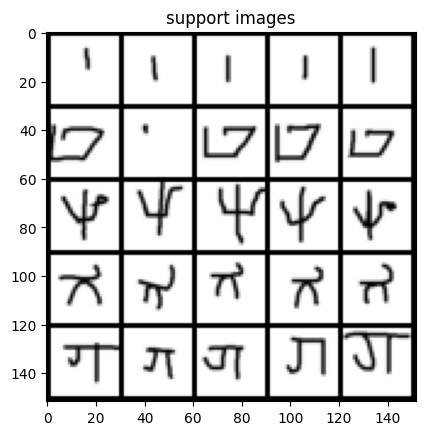

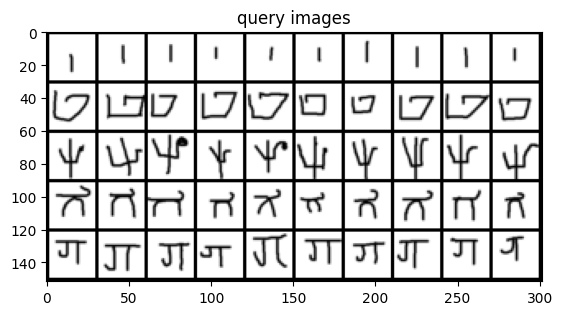

In [7]:
# the batch is deconstructed in 5 variables
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader)) # extract the next batch from DataLoader

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

For both support and query set, you should have one line for each class.

How does our model perform on this task?

In [8]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1) # we want to find the index of the max value along the dimension of the classes

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
ULOG\character09 / ULOG\character09
ULOG\character09 / ULOG\character09
ULOG\character09 / ULOG\character09
ULOG\character09 / ULOG\character09
ULOG\character09 / ULOG\character09
ULOG\character09 / ULOG\character09
ULOG\character09 / ULOG\character09
ULOG\character09 / ULOG\character09
ULOG\character09 / ULOG\character09
ULOG\character09 / ULOG\character09
Aurek-Besh\character07 / Aurek-Besh\character07
Aurek-Besh\character07 / Manipuri\character02
Aurek-Besh\character07 / Aurek-Besh\character07
Aurek-Besh\character07 / Aurek-Besh\character07
Aurek-Besh\character07 / Old_Church_Slavonic_(Cyrillic)\character40
Aurek-Besh\character07 / Aurek-Besh\character07
Aurek-Besh\character07 / Aurek-Besh\character07
Aurek-Besh\character07 / Aurek-Besh\character07
Aurek-Besh\character07 / Aurek-Besh\character07
Aurek-Besh\character07 / Aurek-Besh\character07
Old_Church_Slavonic_(Cyrillic)\character40 / Old_Church_Slavonic_(Cyrillic)\character40
Old_Church_Slavonic_(Cyrillic

This doesn't look bad: keep in mind that the model was trained on very different images, and has only seen 5 examples for each class!

Now that we have a first idea, let's see more precisely how good our model is.

In [9]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
):
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels) # count the number of true predictions


def evaluate(data_loader: DataLoader): # DataLoader to give the few-shot tasks to evaluate
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        # iterate on the tasks given by the DataLoader
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|██████████| 100/100 [00:05<00:00, 16.80it/s]

Model tested on 100 tasks. Accuracy: 86.62%


With absolutely zero training on Omniglot images, and only 5 examples per class, we achieve around 86% accuracy! Isn't this a great start?

## Training a meta-learning algorithm

Let's use the "background" images of Omniglot as training set. Here we prepare a data loader of 40 000 few-shot classification
tasks on which we will train our model. The alphabets used in the training set are entirely separated from those used in the testing set.
This guarantees that at test time, the model will have to classify characters that were not seen during training.

Note that we don't set a validation set here to keep this notebook concise,
but keep in mind that **this is not good practice** and you should always use validation when training a model for production.

In [10]:
N_TRAINING_EPISODES = 40000 # number of training tasks to generate during the model training
N_VALIDATION_TASKS = 100

train_set.get_labels = lambda: [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

We will keep the same model. So our weights will be pre-trained on ImageNet. If you want to start a training from scratch,
feel free to set `pretrained=False` in the definition of the ResNet.

Here we define our loss and our optimizer (cross entropy and Adam, pretty standard), and a `fit` method.
This method takes a classification task as input (support set and query set). It predicts the labels of the query set
based on the information from the support set; then it compares the predicted labels to ground truth query labels,
and this gives us a loss value. Then it uses this loss to update the parameters of the model. This is a *meta-training loop*.

In [11]:
criterion = nn.CrossEntropyLoss() # the chosen loss is the CrossEntropyLoss
optimizer = optim.Adam(model.parameters(), lr=0.001) # the chosen optimizer is Adam, based on the stochastic gradient


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad() # set to 0 the accumulated gradients during the last backpropagation
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward() # backpropagation
    optimizer.step() # update the weights through the gradients

    return loss.item() # return the loss

To train the model, we are just going to iterate over a large number of randomly generated few-shot classification tasks,
and let the `fit` method update our model after each task. This is called **episodic training**.

In [12]:
log_update_frequency = 10 # log(loss) updated every 10 episodes

all_loss = []
accuracies = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        # Calcolo dell'accuratezza sui dati di query
        with torch.no_grad():
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            accuracy = 100 * correct / total
            accuracies.append(accuracy)

        if episode_index % log_update_frequency == 0: # each 10 episodes the progress bar is updated
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████| 40000/40000 [1:12:21<00:00,  9.21it/s, loss=0.325]


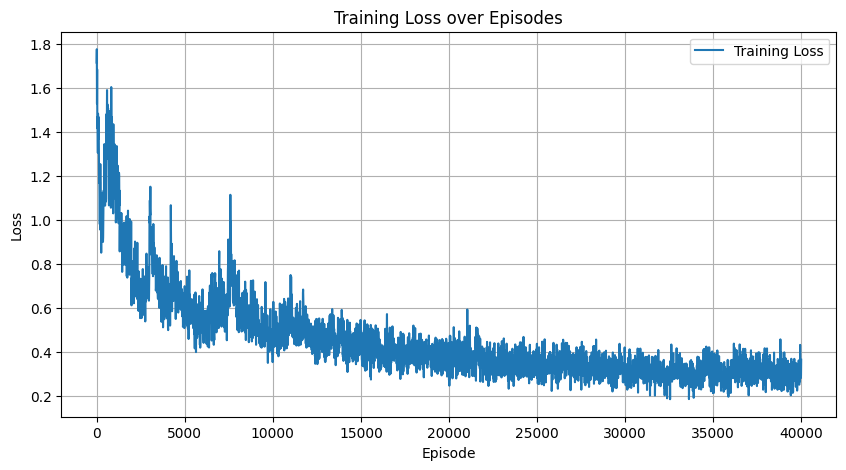

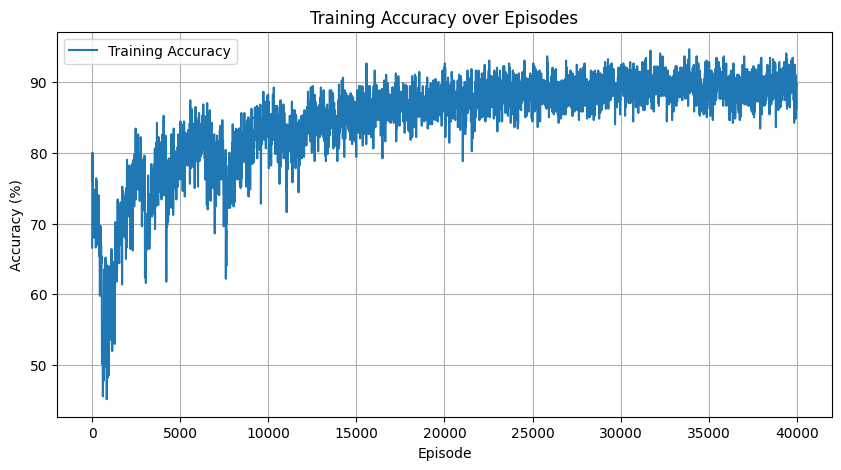

In [13]:
# Funzione per creare il grafico della perdita
def plot_training_loss(all_loss, log_update_frequency):
    plt.figure(figsize=(10, 5))
    smoothed_loss = [sum(all_loss[i:i + log_update_frequency]) / log_update_frequency for i in range(0, len(all_loss), log_update_frequency)]
    plt.plot(range(0, len(all_loss), log_update_frequency), smoothed_loss, label='Training Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Training Loss over Episodes')
    plt.legend()
    plt.grid(True)
    plt.show()

# Funzione per creare il grafico dell'accuratezza
def plot_training_accuracy(training_accuracies, log_update_frequency):
    plt.figure(figsize=(10, 5))
    smoothed_accuracy = [sum(training_accuracies[i:i + log_update_frequency]) / log_update_frequency for i in range(0, len(training_accuracies), log_update_frequency)]
    plt.plot(range(0, len(training_accuracies), log_update_frequency), smoothed_accuracy, label='Training Accuracy')
    plt.xlabel('Episode')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy over Episodes')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualizzazione del grafico dopo il training
plot_training_loss(all_loss, log_update_frequency)
plot_training_accuracy(accuracies, log_update_frequency)

Now let's see if our model got better!

In [14]:
evaluate(test_loader)

100%|██████████| 100/100 [00:06<00:00, 14.77it/s]

Model tested on 100 tasks. Accuracy: 97.94%


Around 98%!

It's not surprising that the model performs better after being further trained on Omniglot images than it was with its
ImageNet-based parameters. However, we have to keep in mind that the classes on which we just evaluated our model were still
**not seen during training**, so 99% (with a 12% improvement over the model trained on ImageNet) seems like a decent performance.